**Attention-Guided GANs (AGGAN) for Unsupervised Image-to-Image Translation** (Tang, Hao & Xu, Dan & Sebe, Nicu & Yan, Yan. (2019). Attention-Guided Generative Adversarial Networks for Unsupervised Image-to-Image Translation.)
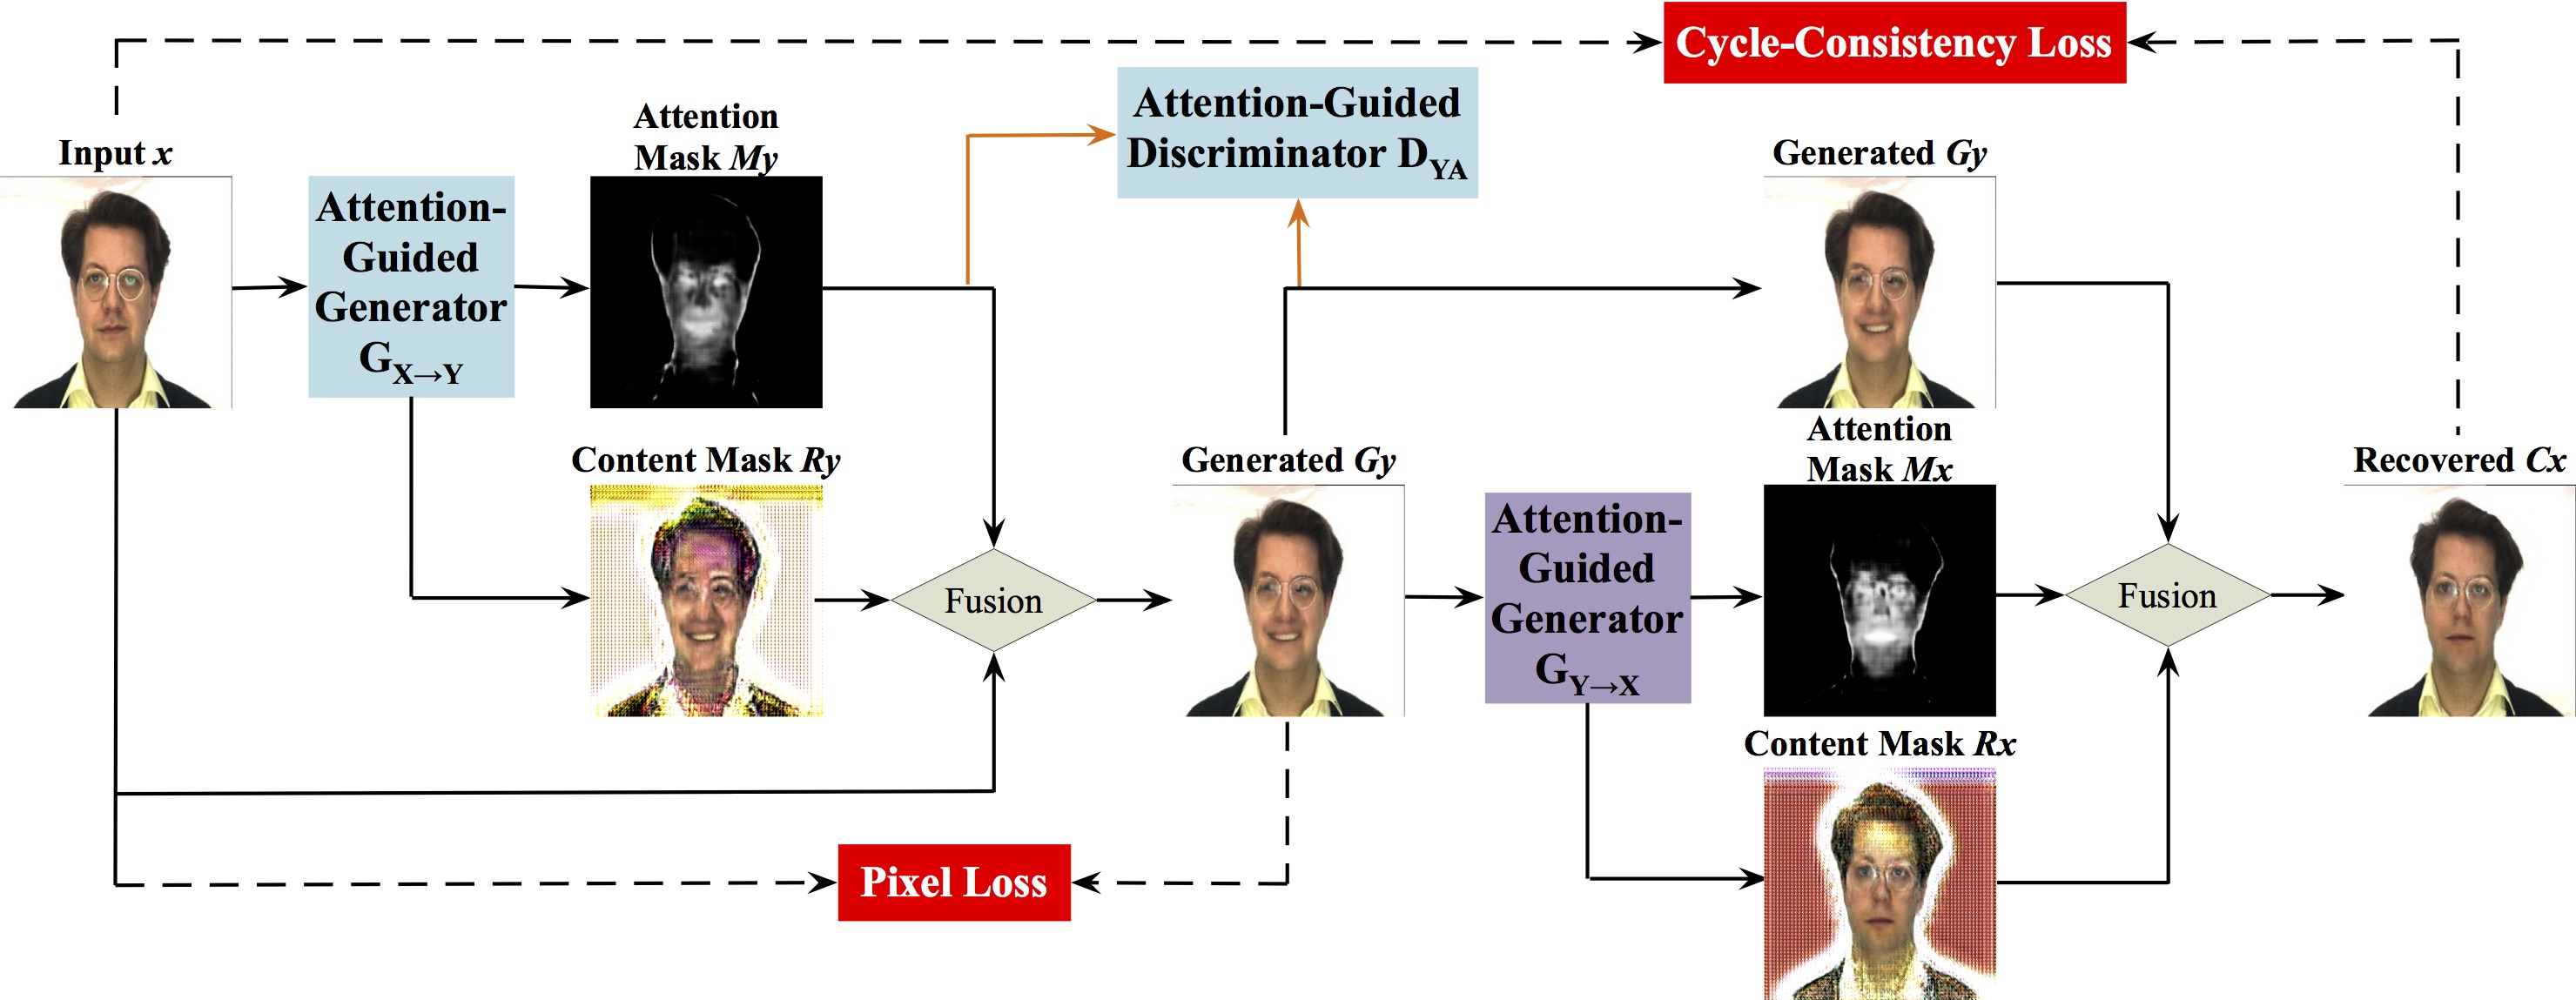

##Utils

In [ ]:
pip install visdom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=d5ef40d719e9768df54f569435b7b37e099534842e7f958e3d9cff4fb80e4ebd
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
from visdom import Visdom
import numpy as np

def print_network(net):
  num_params = 0
  for param in net.parameters():
    num_params += param.numel()
  print(net)
  print('Total number of parameters: %d' % num_params)

def tensor2image(tensor):
  image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
  if image.shape[0] == 1:
    image = np.tile(image, (3,1,1))
  return image.astype(np.uint8)

class Logger():
  def __init__(self, n_epochs, batches_epoch):
    self.viz = Visdom(use_incoming_socket=False)
    self.n_epochs = n_epochs
    self.batches_epoch = batches_epoch
    self.epoch = 1
    self.batch = 1
    self.prev_time = time.time()
    self.mean_period = 0
    self.losses = {}
    self.loss_windows = {}
    self.image_windows = {}


  def log(self, losses=None, images=None):
    self.mean_period += (time.time() - self.prev_time)
    self.prev_time = time.time()

    sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

    for i, loss_name in enumerate(losses.keys()):
      if loss_name not in self.losses:
        self.losses[loss_name] = losses[loss_name].data[0]
      else:
        self.losses[loss_name] += losses[loss_name].data[0]

      if (i+1) == len(losses.keys()):
        sys.stdout.write('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
      else:
        sys.stdout.write('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

      batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
      batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch
      sys.stdout.write('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))

      # Draw images
      for image_name, tensor in images.items():
        if image_name not in self.image_windows:
          self.image_windows[image_name] = self.viz.image(tensor2image(tensor.data), opts={'title':image_name})
        else:
          self.viz.image(tensor2image(tensor.data), win=self.image_windows[image_name], opts={'title':image_name})

        # End of epoch
      if (self.batch % self.batches_epoch) == 0:
        # Plot losses
        for loss_name, loss in self.losses.items():
          if loss_name not in self.loss_windows:
            self.loss_windows[loss_name] = self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]),
                                                         opts={'xlabel': 'epochs', 'ylabel': loss_name, 'title': loss_name})
          else:
            self.viz.line(X=np.array([self.epoch]), Y=np.array([loss/self.batch]), win=self.loss_windows[loss_name], update='append')
            # Reset losses for next epoch
            self.losses[loss_name] = 0.0

        self.epoch += 1
        self.batch = 1
        sys.stdout.write('\n')
      else:
        self.batch += 1


class ReplayBuffer():
  def __init__(self, max_size=50):
    assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
    self.max_size = max_size
    self.data = []

  def push_and_pop(self, data):
    to_return = []
    for element in data.data:
      element = torch.unsqueeze(element, 0)
      if len(self.data) < self.max_size:
        self.data.append(element)
        to_return.append(element)
      else:
        if random.uniform(0,1) > 0.5:
          i = random.randint(0, self.max_size-1)
          to_return.append(self.data[i].clone())
          self.data[i] = element
        else:
          to_return.append(element)
    return Variable(torch.cat(to_return))

class LambdaLR():
  def __init__(self, n_epochs, offset, decay_start_epoch):
    assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
    self.n_epochs = n_epochs
    self.offset = offset
    self.decay_start_epoch = decay_start_epoch

  def step(self, epoch):
    return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

## Dataset

In [ ]:
import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
  def __init__(self, root, transforms_=None, unaligned=False):
    self.transform = transforms.Compose(transforms_)
    self.unaligned = unaligned
    self.files_A = sorted(glob.glob(os.path.join(root, 'A') + '/*.jpg'))
    self.files_B = sorted(glob.glob(os.path.join(root, 'B') + '/*.jpg'))

  def __getitem__(self, index):
    item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

    if self.unaligned:
      item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
    else:
      item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

    return {'A': item_A, 'B': item_B}

  def __len__(self):
    return max(len(self.files_A), len(self.files_B))

## Model

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class Generator(nn.Module):
  def __init__(self, input_nc=3, output_nc=4, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6):
    assert(n_blocks >= 0)
    super(Generator, self).__init__()
    self.input_nc = input_nc
    self.output_nc = output_nc
    self.ngf = ngf

    model = [nn.ReflectionPad2d(3),
             nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
             norm_layer(ngf),
             nn.ReLU(True)]

    n_downsampling = 2
    for i in range(n_downsampling):
      mult = 2**i
      model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                          stride=2, padding=1),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)]

      mult = 2**n_downsampling
    for i in range(n_blocks):
      model += [ResnetBlock(ngf * mult, norm_layer=norm_layer, use_dropout=use_dropout)]

    for i in range(n_downsampling):
      mult = 2**(n_downsampling - i)
      model += [nn.ReflectionPad2d(1),
                nn.Conv2d(ngf * mult, int(ngf * mult / 2),
                          kernel_size=3, stride=1),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True),
                nn.Conv2d(int(ngf * mult / 2), int(ngf * mult / 2)*4,
                          kernel_size=1, stride=1),
                nn.PixelShuffle(2),
                norm_layer(int(ngf * mult / 2)),
                  nn.ReLU(True),
                 ]
    model += [nn.ReflectionPad2d(3)]
    model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]

    self.model = nn.Sequential(*model)

  def forward(self, input):
    output = self.model(input)
    attention_mask = F.sigmoid(output[:, :1])
    content_mask = output[:, 1:]
    attention_mask = attention_mask.repeat(1, 3, 1, 1)
    result = content_mask * attention_mask + input * (1 - attention_mask)

    return result, attention_mask, content_mask

class ResnetBlock(nn.Module):
  def __init__(self, dim, norm_layer, use_dropout):
    super(ResnetBlock, self).__init__()
    self.conv_block = self.build_conv_block(dim, norm_layer, use_dropout)

  def build_conv_block(self, dim, norm_layer, use_dropout):
    conv_block = [nn.ReflectionPad2d(1),
                  nn.Conv2d(dim, dim, kernel_size=3),
                  norm_layer(dim),
                  nn.ReLU(True)]
    if use_dropout:
      conv_block += [nn.Dropout(0.5)]

    conv_block += [nn.ReflectionPad2d(1),
                    nn.Conv2d(dim, dim, kernel_size=3),
                    norm_layer(dim)]

    return nn.Sequential(*conv_block)

  def forward(self, x):
    out = x + self.conv_block(x)
    return out


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv_tower = nn.Sequential(
        nn.Conv2d(3,   64,  4, 2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1),
        nn.Conv2d(64,  128,  4, 2),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),
        nn.Conv2d(128,  256,  4, 2),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.1),
        nn.Conv2d(256,  512, 4, 2),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.1),
        nn.Conv2d(512, 512, 4),
        nn.LeakyReLU(0.1),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(512, 1, 1),
    )

  def forward(self, img):
    output = self.conv_tower(img)
    return output

## Train

In [ ]:
import argparse
import itertools
import sys
import os
import glob
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from PIL import Image
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.utils import save_image
import torchvision
from visdom import Visdom
import numpy as np

In [ ]:
#!/usr/bin/python3

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
parser.add_argument('--n_epochs', type=int, default=120, help='number of epochs of training')
parser.add_argument('--batchSize', type=int, default=1, help='size of the batches')
parser.add_argument('--dataroot', type=str, default='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/dataset_aggan/train/', help='root directory of the dataset')
parser.add_argument('--save_name', type=str, default='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/aggan_saved_models/')
parser.add_argument('--lr', type=float, default=0.0001, help='initial learning rate')
parser.add_argument('--decay_epoch', type=int, default=80, help='epoch to start linearly decaying the learning rate to 0')
parser.add_argument('--size', type=int, default=256, help='size of the data crop (squared assumed)')
parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
parser.add_argument('--cuda', action='store_true', default=True, help='use GPU computation')
parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
parser.add_argument('--lambda_cycle', type=int, default=10)
parser.add_argument('--lambda_identity', type=int, default=0.5)
parser.add_argument('--lambda_pixel', type=int, default=1)
parser.add_argument('--lambda_reg', type=float, default=1e-6)

parser.add_argument('--gan_curriculum', type=int, default=20, help='Strong GAN loss for certain period at the beginning')
parser.add_argument('--starting_rate', type=float, default=0.01, help='Set the lambda weight between GAN loss and Recon loss during curriculum period at the beginning. We used the 0.01 weight.')
parser.add_argument('--default_rate', type=float, default=0.1, help='Set the lambda weight between GAN loss and Recon loss after curriculum period. We used the 0.5 weight.')


_StoreAction(option_strings=['--default_rate'], dest='default_rate', nargs=None, const=None, default=0.1, type=<class 'float'>, choices=None, required=False, help='Set the lambda weight between GAN loss and Recon loss after curriculum period. We used the 0.5 weight.', metavar=None)

In [ ]:
opt = parser.parse_args("")
print(opt)

Namespace(epoch=0, n_epochs=120, batchSize=1, dataroot='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/dataset_aggan/train/', save_name='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/aggan_saved_models/', lr=0.0001, decay_epoch=80, size=256, input_nc=3, output_nc=3, cuda=True, n_cpu=8, lambda_cycle=10, lambda_identity=0.5, lambda_pixel=1, lambda_reg=1e-06, gan_curriculum=20, starting_rate=0.01, default_rate=0.1)


In [ ]:
###### Definition of variables ######
# Networks
netG_A2B = Generator()
netG_B2A = Generator()
netD_A = Discriminator()
netD_B = Discriminator()

print('---------- Networks initialized -------------')
print_network(netG_A2B)
print_network(netG_B2A)
print_network(netD_A)
print_network(netD_B)
print('-----------------------------------------------')

if opt.cuda:
  netG_A2B.cuda()
  netG_B2A.cuda()
  netD_A.cuda()
  netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=0.0001, betas=(0.5, 0.9))
optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()),
                                lr=0.0004, betas=(0.5, 0.9))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_ = [transforms.Resize((opt.size,opt.size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])]


---------- Networks initialized -------------
Generator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d

In [ ]:
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_= transforms_, unaligned=True),
                        batch_size=1, shuffle=True, num_workers=2)

In [ ]:
len(ImageDataset(opt.dataroot))

10237

In [ ]:
# Loss plot
logger = Logger(opt.n_epochs, len(dataloader))

In [ ]:
torch.cuda.empty_cache()

don't run for the first time

In [ ]:
netG_A2B.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netG_A2B.tar'))['model_state_dict'])
netG_B2A.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netG_B2A.tar'))['model_state_dict'])
netD_A.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netD_A.tar'))['model_state_dict'])
netD_B.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netD_B.tar'))['model_state_dict'])
epoch_ckpt=torch.load('%s/%s' % (opt.save_name, 'netG_A2B.tar'))['epoch']
optimizer_G.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netG_A2B.tar'))['optimizer_state_dict'])
optimizer_D.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netD_A.tar'))['optimizer_state_dict'])

In [ ]:
torch.set_grad_enabled(True)

In [ ]:
###### Training ######
for epoch in range(epoch_ckpt+1, opt.n_epochs):
#for epoch in range(opt.epoch, opt.n_epochs):
  for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    ###### Generators A2B and B2A ######
    optimizer_G.zero_grad()

    # Identity loss
    # G_A2B(B) should equal B if real B is fed
    same_B, _, _ = netG_A2B(real_B)
    loss_identity_B = criterion_identity(same_B, real_B)*opt.lambda_identity
    # G_B2A(A) should equal A if real A is fed
    same_A, _, _ = netG_B2A(real_A)
    loss_identity_A = criterion_identity(same_A, real_A)*opt.lambda_identity

    # GAN loss
    fake_B, mask_B, temp_B = netG_A2B(real_A)
    recovered_A, _, _ = netG_B2A(fake_B)
    pred_fake_B = netD_B(fake_B)

    loss_cycle_ABA = criterion_cycle(recovered_A, real_A)
    loss_GAN_A2B = criterion_GAN(pred_fake_B, target_real)
    loss_pix_A = criterion_identity(fake_B, real_A)

    fake_A, mask_A, temp_A = netG_B2A(real_B)
    recovered_B, _, _  = netG_A2B(fake_A)
    pred_fake_A = netD_A(fake_A)

    loss_cycle_BAB = criterion_cycle(recovered_B, real_B)
    loss_GAN_B2A = criterion_GAN(pred_fake_A, target_real)
    loss_pix_B = criterion_identity(fake_A, real_B)

    loss_reg_A = opt.lambda_reg * (
            torch.sum(torch.abs(mask_A[:, :, :, :-1] - mask_A[:, :, :, 1:])) +
            torch.sum(torch.abs(mask_A[:, :, :-1, :] - mask_A[:, :, 1:, :])))

    loss_reg_B = opt.lambda_reg * (
            torch.sum(torch.abs(mask_B[:, :, :, :-1] - mask_B[:, :, :, 1:])) +
            torch.sum(torch.abs(mask_B[:, :, :-1, :] - mask_B[:, :, 1:, :])))

    # Total loss
    if epoch < opt.gan_curriculum:
      rate = opt.starting_rate
      print('using curriculum gan')
    else:
      rate = opt.default_rate
      print('using normal gan')

    loss_G = ((loss_GAN_A2B + loss_GAN_B2A)*0.5 + (loss_reg_A + loss_reg_B))* (1.-rate) + ((loss_cycle_ABA + loss_cycle_BAB)*opt.lambda_cycle+(loss_pix_B+loss_pix_A)*opt.lambda_pixel)* rate

    loss_G.backward()
    optimizer_G.step()
    ###################################

    optimizer_D.zero_grad()

    # Real loss
    pred_real_A = netD_A.forward(real_A)
    loss_D_real_A = criterion_GAN(pred_real_A, target_real)

    # Fake loss
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake_A = netD_A.forward(fake_A.detach())
    loss_D_fake_A = criterion_GAN(pred_fake_A, target_fake)

    # Real loss
    pred_real_B = netD_B.forward(real_B)
    loss_D_real_B = criterion_GAN(pred_real_B, target_real)

    # Fake loss
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake_B = netD_B.forward(fake_B.detach())
    loss_D_fake_B = criterion_GAN(pred_fake_B, target_fake)

        # Total loss
    loss_D = (loss_D_real_B + loss_D_fake_B + loss_D_real_A + loss_D_fake_A)*0.5

    loss_D.backward()
    optimizer_D.step()

    print('Epoch [%d/%d], Batch [%d/%d], loss_D: %.4f, loss_G: %.4f' % (epoch+1, opt.n_epochs,i+1, len(dataloader), loss_D.data, loss_G.data))
    print('loss_GAN_A2B: %.4f, loss_GAN_B2A: %.4f, loss_cycle_ABA: %.4f, loss_cycle_BAB: %.4f, loss_identity_A: %.4f, loss_identity_B: %.4f, loss_pix_A: %.4f, loss_pix_B: %.4f' % (loss_GAN_A2B.data,
        loss_GAN_B2A.data, loss_cycle_ABA.data, loss_cycle_BAB.data, loss_identity_A.data, loss_identity_B.data, loss_pix_A.data, loss_pix_B.data))

    save_path=os.path.join(opt.save_name, 'training')
    if not os.path.exists(save_path):
      os.makedirs(save_path)
    '''
    save_image(torch.cat([
        real_A.data.cpu() * 0.5 + 0.5,
        mask_B.data.cpu(),
        fake_B.data.cpu()*0.5+0.5, temp_B.data.cpu()*0.5+0.5], 2),
        '%s/%04d_%04d_progress_B.png' % (save_path,epoch+1,i+1))

    save_image(torch.cat([
        real_B.data.cpu()* 0.5 + 0.5,
        mask_A.data.cpu(),
        fake_A.data.cpu()*0.5+0.5, temp_A.data.cpu()*0.5+0.5], 2),
        '%s/%04d_%04d_progress_A.png' % (save_path,epoch+1,i+1))
     '''
  # Update learning rates
  lr_scheduler_G.step()
  lr_scheduler_D.step()

  torch.save({'epoch': epoch,
              'model_state_dict': netG_A2B.state_dict(),
              'optimizer_state_dict':optimizer_G.state_dict(),
              'loss': loss_G,
              'scheduler': lr_scheduler_G.state_dict()},
             '%s/%s' % (opt.save_name, 'netG_A2B.tar'))
  torch.save({'epoch': epoch,
              'model_state_dict': netG_B2A.state_dict(),
              'optimizer_state_dict': optimizer_G.state_dict(),
              'loss': loss_G,
              'scheduler': lr_scheduler_G.state_dict()},
             '%s/%s' % (opt.save_name, 'netG_B2A.tar'))
  torch.save({'epoch': epoch,
              'model_state_dict': netD_A.state_dict(),
              'optimizer_state_dict': optimizer_D.state_dict(),
              'loss': loss_D,
              'scheduler': lr_scheduler_D.state_dict()},
             '%s/%s' % (opt.save_name, 'netD_A.tar'))
  torch.save({'epoch': epoch,
              'model_state_dict': netD_B.state_dict(),
              'optimizer_state_dict': optimizer_D.state_dict(),
              'loss': loss_D,
              'scheduler': lr_scheduler_D.state_dict()},
             '%s/%s' % (opt.save_name, 'netD_B.tar'))

## Test

In [ ]:
import argparse
import sys
import os

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

#from models import Generator
#from datasets import ImageDataset

parser2 = argparse.ArgumentParser()
parser2.add_argument('--batchSize', type=int, default=1, help='size of the batches')
parser2.add_argument('--save_name', type=str, default='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/aggan_saved_models/')
parser2.add_argument('--dataroot', type=str, default='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/dataset_aggan/test/', help='root directory of the dataset')
parser2.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser2.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
parser2.add_argument('--size', type=int, default=256, help='size of the data (squared assumed)')
parser2.add_argument('--cuda', action='store_true', help='use GPU computation')
parser2.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')


_StoreAction(option_strings=['--n_cpu'], dest='n_cpu', nargs=None, const=None, default=8, type=<class 'int'>, choices=None, required=False, help='number of cpu threads to use during batch generation', metavar=None)

In [ ]:
opt2 = parser2.parse_args("")
print(opt2)

Namespace(batchSize=1, save_name='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/aggan_saved_models/', dataroot='/content/drive/MyDrive/8thSemester/MajorProject/Dataset/CelebA/dataset_aggan/test/', input_nc=3, output_nc=3, size=256, cuda=False, n_cpu=8)


In [ ]:
###### Definition of variables ######
# Networks
netG_A2B = Generator()
netG_B2A = Generator()

if opt.cuda:
  netG_A2B.cuda()
  netG_B2A.cuda()

# Load state dicts
netG_A2B.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netG_A2B.tar'))['model_state_dict'])
netG_B2A.load_state_dict(torch.load('%s/%s' % (opt.save_name, 'netG_B2A.tar'))['model_state_dict'])

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt2.batchSize, opt2.input_nc, opt2.size, opt2.size)
input_B = Tensor(opt2.batchSize, opt2.output_nc, opt2.size, opt2.size)

# Dataset loader
transforms_ = [ transforms.Resize((opt2.size,opt2.size)),
               transforms.ToTensor(),
               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
test_dataloader = DataLoader(ImageDataset(opt2.dataroot, transforms_=transforms_),
                        batch_size=opt2.batchSize, shuffle=False, num_workers=2)

# Create output dirs if they don't exist
if not os.path.exists('%s/%s' % (opt.save_name, 'testing')):
  os.makedirs('%s/%s' % (opt.save_name, 'testing'))


In [ ]:
len(test_dataloader)

524

In [ ]:
for i, batch in enumerate(test_dataloader):
  # Set model input
  real_A = Variable(input_A.copy_(batch['A']))
  real_B = Variable(input_B.copy_(batch['B']))

  # Generate output
  fake_B, mask_B, temp_B = netG_A2B(real_A)
  fake_B_1 = 0.5*fake_B.data[0] + 0.5
  fake_B_2 = 0.5*temp_B.data[0] + 0.5
  fake_A, mask_A, temp_A = netG_B2A(real_B)
  fake_A_1 = 0.5*fake_A.data[0] + 0.5
  fake_A_2 = 0.5*temp_A.data[0] + 0.5

  # Save image files
  save_image(real_A.data.cpu()[0]*0.5+0.5, '%s/%s/%04d_real_A.png' % (opt.save_name, 'testing', i+1))
  save_image(real_B.data.cpu()[0]*0.5+0.5, '%s/%s/%04d_real_B.png' % (opt.save_name, 'testing',i+1))
  save_image(fake_A_1, '%s/%s/%04d_fake_A_1.png' % (opt.save_name, 'testing',i+1))
  save_image(fake_B_1, '%s/%s/%04d_fake_B_1.png' % (opt.save_name, 'testing',i+1))
  save_image(fake_A_2, '%s/%s/%04d_fake_A_2.png' % (opt.save_name, 'testing',i+1))
  save_image(fake_B_2, '%s/%s/%04d_fake_B_2.png' % (opt.save_name, 'testing',i+1))
  save_image(mask_A.data.cpu()[0], '%s/%s/%04d_mask_A.png' % (opt.save_name, 'testing',i+1))
  save_image(mask_B.data.cpu()[0], '%s/%s/%04d_mask_B.png' % (opt.save_name, 'testing',i+1))

  sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(test_dataloader)))

sys.stdout.write('\n')

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Generated images 0524 of 10237
